In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import RIfunctions as ri

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, recall_score

In [3]:
data = pd.read_csv('input_file_1.csv', sep = ',', index_col=0)

C:\Users\joshy\AppData\Roaming\Python\Python38\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
Counter(data['rejected']).values()

dict_values([14739886, 814643])

In [5]:
data['issue_d'] = pd.to_datetime(data['issue_d'])

In [6]:
data = ri.purposeCleaning(data)
print(data['purpose'].value_counts())

debt_consolidation    7546401
other                 2221728
credit_card           1860430
home_improvement       885793
car                    648401
major_purchase         526632
medical                431641
moving                 424642
small_business         288705
house                  217598
vacation               199162
Business                85413
renewable_energy        28281
wedding                 19635
Name: purpose, dtype: int64


In [7]:
data = pd.get_dummies(data, columns=['purpose'], drop_first=False)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15384462 entries, 0 to 814642
Data columns (total 19 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   dti                         float64       
 1   emp_length                  float64       
 2   issue_d                     datetime64[ns]
 3   loan_amnt                   float64       
 4   rejected                    int64         
 5   purpose_Business            uint8         
 6   purpose_car                 uint8         
 7   purpose_credit_card         uint8         
 8   purpose_debt_consolidation  uint8         
 9   purpose_home_improvement    uint8         
 10  purpose_house               uint8         
 11  purpose_major_purchase      uint8         
 12  purpose_medical             uint8         
 13  purpose_moving              uint8         
 14  purpose_other               uint8         
 15  purpose_renewable_energy    uint8         
 16  purpose_small_busi

In [9]:
# Train the model on the full dataset. We are trying to build a pre-existing, trained model, not a new model.

y_train = data['rejected']
X_train = data.drop(['rejected', 'issue_d'], axis=1)

In [10]:
# data_train = data.loc[data['issue_d'] < data['issue_d'].quantile(0.75)]
# data_test = data.loc[data['issue_d'] >= data['issue_d'].quantile(0.75)]

# data_train.drop('issue_d', axis=1, inplace=True)
# data_test.drop('issue_d', axis=1, inplace=True)

# y_train = data_train['rejected']
# y_test = data_test['rejected']

# X_train = data_train.drop('rejected', axis=1)
# X_test = data_test.drop('rejected', axis=1)

In [13]:
# # Optimisation

# pipeline_sgdlogreg = Pipeline([
#     ('imputer', SimpleImputer(copy=False)), # Mean imputation by default
#     ('scaler', StandardScaler(copy=False)),
#     ('model',LogisticRegression(
#         class_weight='balanced',
#         random_state=1,
#         n_jobs=10,
#         warm_start=True
#         )
#     )
# ])

# param_grid_sgdlogreg = {
#     'model__penalty': ['l1', 'l2'],
#     'model__max_iter': [20, 50, 100, 200, 500, 1000],                      
#     'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] # Optimisation algorithm
# }

# grid_sgdlogreg = GridSearchCV(
#     estimator=pipeline_sgdlogreg,
#     param_grid=param_grid_sgdlogreg,
#     scoring='roc_auc',
#     pre_dispatch=3,
#     n_jobs=-1,
#     cv=1,
#     verbose=1,
#     return_train_score=False
# )

# grid_sgdlogreg.fit(X_train, y_train)

# print(grid_sgdlogreg.best_estimator_,grid_sgdlogreg.best_params_, grid_sgdlogreg.best_score_)

In [14]:
# Hyperparemeters already optimised

pipeline_sgdlogreg = Pipeline([
    ('imputer', SimpleImputer(copy=False)), # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    ('model', LogisticRegression(
        class_weight='balanced',
        max_iter=1000, 
        tol = 1e-3,
        random_state=1,
        n_jobs=-1,
        warm_start=True,
        penalty='l2'
        )
    )
])

In [15]:
pipeline_sgdlogreg.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(copy=False)),
                ('scaler', StandardScaler(copy=False)),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1, random_state=1, tol=0.001,
                                    warm_start=True))])

In [16]:
y_score = pipeline_sgdlogreg.predict_proba(X_train)[:,1]

y_score_flag = [int(round(i)) for i in y_score]

'''Two ways of evaluating results, check that they match.'''

print('LOOK FOR DISCREPANCIES HERE...')

print(roc_auc_score(y_train, y_score), recall_score(y_train, y_score_flag, pos_label=1), recall_score(y_train, y_score_flag, pos_label=0))

LOOK FOR DISCREPANCIES HERE...
0.8875425525574205 0.8594897016103206 0.7424194419884075


In [17]:
y_score_flag = pipeline_sgdlogreg.predict(X_train)

print(roc_auc_score(y_train, y_score), recall_score(y_train, y_score_flag, pos_label=1), recall_score(y_train, y_score_flag, pos_label=0))

0.8875425525574205 0.8594897016103206 0.7424194419884075


In [18]:
data['score'] = np.hstack(y_score)


In [19]:
def undummy(d):
    return d.dot(d.columns)

data = data.assign(purpose=data.filter(regex='^purpose').pipe(undummy))
data['purpose'] = data['purpose'].str.replace("purpose_","")
data = data[data.columns.drop(list(data.filter(regex="purpose_")))]

In [20]:
data.to_csv('AR Scores.csv', mode='w+')

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

NameError: name 'plt' is not defined

Confusion matrix, without normalization
[[858  75]
 [ 98 161]]


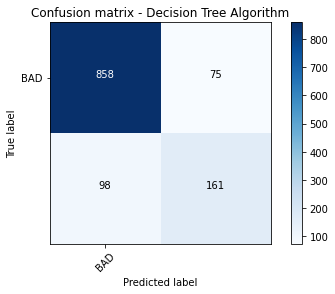

In [ ]:
# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_test, y_predict)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"],
                      title='Confusion matrix - Decision Tree Algorithm')

plt.show()